# Train a simple neural network with Pytorch
Tanay Dangaich

In [11]:
#Collaborated with Vivek Atal

import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
import math
%matplotlib inline
import torch
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import time
from sklearn.preprocessing import StandardScaler

In [2]:
from ctypes import sizeof
rng = np.random.default_rng(seed=42)
raw_data = rng.random(20000)
raw_data[0:10000]

X_data = raw_data[0:10000] * 3 - 1.5
print(X_data.shape)

Y_data = raw_data[10000:20000] * 2 - 1
print(Y_data.shape)

Label = (X_data**2 * (np.sin(3*X_data))**2 + Y_data**2 < 0.4).astype(int)
print(Label.shape)

(10000,)
(10000,)
(10000,)


In [3]:
observations = np.column_stack((X_data,Y_data, Label))
df = pd.DataFrame(observations)
print(df)
class_0=df.loc[df[2] == 0]
class_1=df.loc[df[2] == 1]
torch.is_tensor(observations)

             0         1    2
0     0.821868  0.441457  0.0
1    -0.183365  0.422476  1.0
2     1.075794 -0.594610  1.0
3     0.592104 -0.926689  0.0
4    -1.217468 -0.392401  0.0
...        ...       ...  ...
9995 -0.159759  0.624688  1.0
9996 -0.571958  0.055909  1.0
9997 -1.003959  0.694262  0.0
9998 -0.379769  0.341606  1.0
9999 -0.057277 -0.717480  0.0

[10000 rows x 3 columns]


False

<ipython-input-4-16985edfdb54>:2: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(x, -np.sqrt(0.4-x**2 * np.sin(3*x)**2), np.sqrt(0.4-x**2 * np.sin(3*x)**2), color='red')


<function matplotlib.pyplot.show(*args, **kw)>

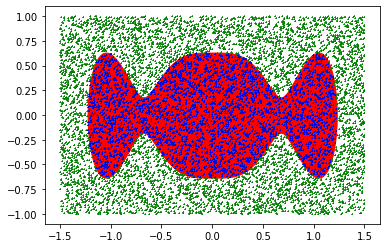

In [4]:
x = np.arange(-1.5, 1.5, 0.0001)
plt.fill_between(x, -np.sqrt(0.4-x**2 * np.sin(3*x)**2), np.sqrt(0.4-x**2 * np.sin(3*x)**2), color='red')
#                     lower bound data^^^^^,                       upper bound data^^^^
#we are using the equation to generate a bunch of points using the function and solving it for y at the border which is 0.4

plt.scatter(X_data, Y_data, c = 'green', s = 1, marker = '+')
plt.scatter(class_1[0], class_1[1], s = 1, c= 'blue', marker = '+')
plt.show
#why am I not getting the blue overlapping part? use plt.fill_between

In [5]:
# A helper function to move various types of objects to a device
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

def run_epoch(model, optimizer, data_loader, loss_func, device, 
              results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        #print(f'input shape {inputs.shape}')

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch


def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, 
                                      device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, 
                          results, score_funcs, prefix="test", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [6]:
import torch.nn as nn
model_gd = nn.Sequential(
    nn.Linear(2,  25),
    nn.ReLU(),
    nn.Linear(25,  25),
    nn.ReLU(),
    nn.Linear(25, 25),
    nn.ReLU(),
    nn.Linear(25, 2),
)

In [7]:
torch.tensor(Label).shape

torch.Size([10000])

In [13]:
# Set seed for reproducibility
generator = torch.Generator().manual_seed(52)

# Convert data to tensors
Feature = torch.tensor(np.column_stack((X_data, Y_data))).to(torch.float32)
Label_tensor = torch.tensor(Label).to(torch.long)


# Create dataset from features and labels
dataset = torch.utils.data.TensorDataset(Feature, Label_tensor)

# Perform 70:30 split of dataset
train_ds, test_ds = torch.utils.data.random_split(dataset, [0.7 ,0.3], generator)

#normalize data using StandardScaler()

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader


training_loader = DataLoader(dataset, batch_size=32,shuffle=True)

testing_loader = DataLoader(test_ds)

model = model_gd

loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50, device="cpu",
                     test_loader=testing_loader, score_funcs={'Acc':accuracy_score,'F1': f1_score})

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/3000 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,0.969491,0.667848,0.658576,0.6046,0.606667,0.078322,0.000000
1,1,1.310967,0.649755,0.642843,0.6112,0.606667,0.000000,0.000000
2,2,1.655839,0.628834,0.616250,0.6112,0.606667,0.000000,0.000000
3,3,2.009490,0.591968,0.565160,0.6304,0.686667,0.094118,0.338028
4,4,2.518819,0.525523,0.480681,0.7581,0.812667,0.552948,0.697524
5,5,3.030389,0.434357,0.387597,0.8382,0.859333,0.754923,0.802988
6,6,3.694312,0.358336,0.329942,0.8649,0.872667,0.813320,0.829920
7,7,4.654754,0.317896,0.301638,0.8720,0.877667,0.829379,0.837539
8,8,5.428607,0.298688,0.288608,0.8736,0.876333,0.833421,0.836203
9,9,6.168354,0.288046,0.278408,0.8775,0.882000,0.839681,0.844053
